In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors as colors
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def read_npy(paths,sep=2):
    npys = []
    for i,path in enumerate(paths):
        npys.append(np.load(path))
        if i % sep == 0:
            print(f'{i}:Loading {path} {npys[-1].shape}')
    print(f'Total of {len(npys)} files loaded')
    return npys

In [4]:
!ls /mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-14-scale-1/valid-out

TurbPar.out2.00103.hdf5-rhop_swag_out.npy
TurbPar.out2.00103.hdf5-vrel_swag_out.npy
TurbPar.out2.00106.hdf5-rhop_swag_out.npy
TurbPar.out2.00106.hdf5-vrel_swag_out.npy


In [5]:
fstring = '/mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-{}-scale-1/valid-out'

In [6]:
paths = [fstring.format(np.random.randint(20)) for i in range(5)]
paths

['/mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-12-scale-1/valid-out',
 '/mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-17-scale-1/valid-out',
 '/mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-7-scale-1/valid-out',
 '/mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-16-scale-1/valid-out',
 '/mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-11-scale-1/valid-out']

In [7]:
rhop_paths = [f'{p}/TurbPar.out2.00103.hdf5-rhop_swag_out.npy' for p in paths]
vrel_paths = [f'{p}/TurbPar.out2.00103.hdf5-vrel_swag_out.npy' for p in paths]

In [8]:
rhop_slices = read_npy(rhop_paths)
vrel_slices = read_npy(vrel_paths)

0:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-12-scale-1/valid-out/TurbPar.out2.00103.hdf5-rhop_swag_out.npy (1, 256, 256, 256)
2:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-7-scale-1/valid-out/TurbPar.out2.00103.hdf5-rhop_swag_out.npy (1, 256, 256, 256)
4:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-11-scale-1/valid-out/TurbPar.out2.00103.hdf5-rhop_swag_out.npy (1, 256, 256, 256)
Total of 5 files loaded
0:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-12-scale-1/valid-out/TurbPar.out2.00103.hdf5-vrel_swag_out.npy (3, 256, 256, 256)
2:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-7-scale-1/valid-out/TurbPar.out2.00103.hdf5-vrel_swag_out.npy (3, 256, 256, 256)
4:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/swag-train/verify-11-scale-1/valid-out/TurbPar.out2.00103.hdf5-vrel_swag_out.npy (3, 256, 256, 256)
Total of 5 files loaded


In [31]:
rhop_avg = sum(rhop_slices)/len(rhop_slices)
vrel_avg = sum(vrel_slices)/len(vrel_slices)

In [72]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

1.6689299e-08


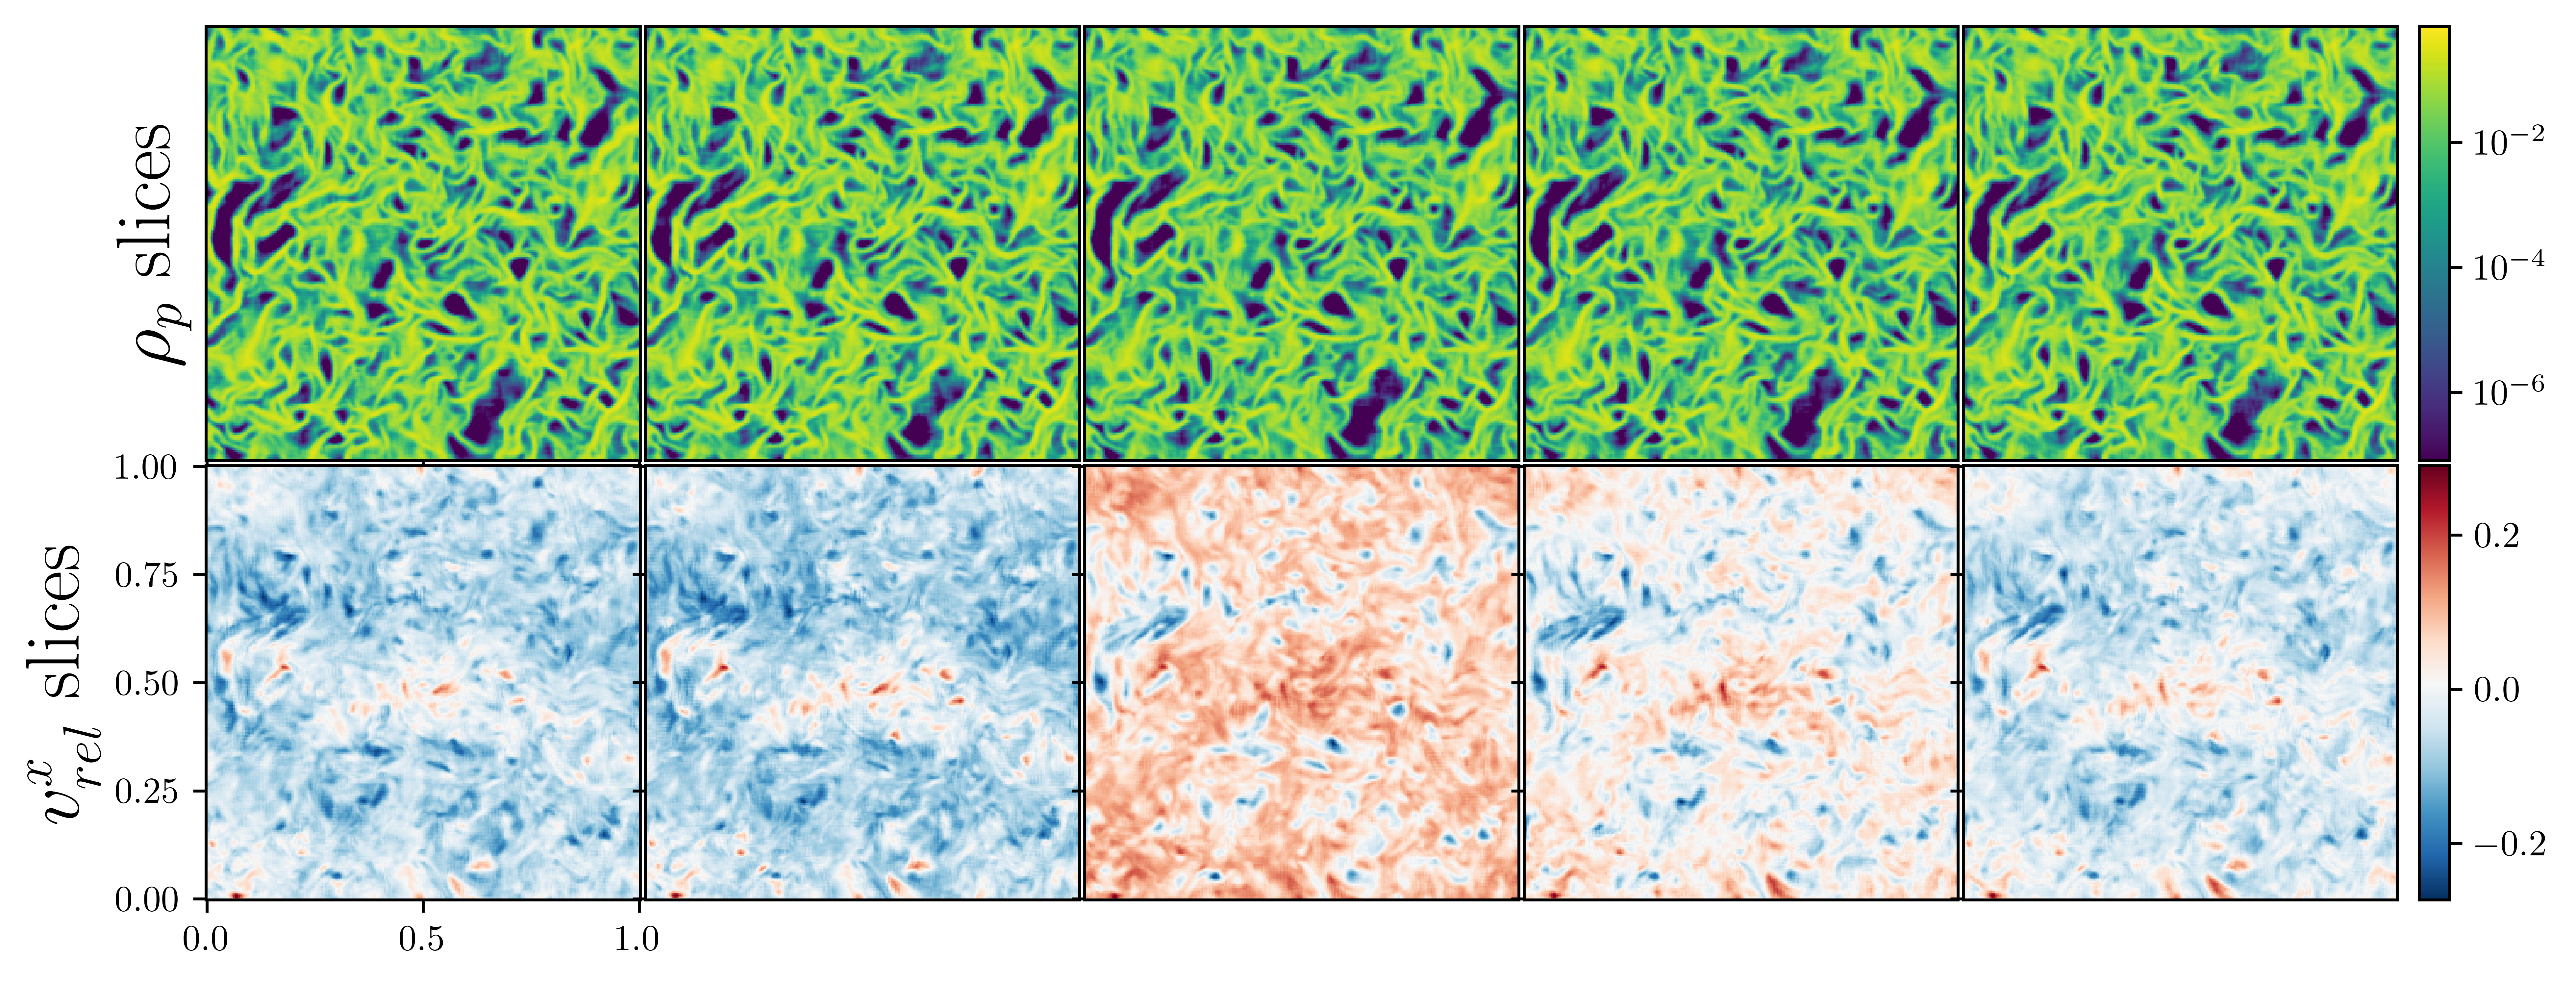

In [83]:
with PdfPages('swag_slice_compare.pdf') as pdf:
    fig = plt.figure(figsize=(11,5),dpi=800)
    grid = AxesGrid(fig,111,
                    nrows_ncols=(2,5),
                    #label_mode='1',
                    #share_all='row',
                    cbar_location='right',
                    cbar_mode='edge',
                    cbar_size='7%',
                    cbar_pad='5%')
    x=np.linspace(0,1,256)
    y=np.linspace(0,1,256)
    X,Y = np.meshgrid(x,y)

    for i in range(5):
        rhop_error = ((abs(rhop_slices[i]-rhop_avg))/(rhop_avg+eps))
        if i == 0:
            ql,qh = 8.198381067359137e-08, 0.7232698917388913
            eps = np.unique(rhop_slices[i])[1]
            print(eps)
        im = grid[i].pcolormesh(X,Y,rhop_slices[i][0,256//2,:,:]+eps,
                           rasterized=True,shading='auto',
                           norm=colors.LogNorm(vmin=ql, vmax=qh)
                          )
    grid.cbar_axes[0].colorbar(im)
    grid[0].set_ylabel(r'$\rho_p$ slices',fontsize=21)
    grid[0].set_yticks([])

    for i in range(5):
        velc_deviation = np.sqrt(np.sum((vrel_slices[i]-vrel_avg)**2,axis=0))
        velc_err = (velc_deviation/(np.abs(np.sqrt(np.sum(vrel_avg**2,axis=0)))+eps))
        velc_x = vrel_slices[i][0]
        if i == 0:
            ql,qh = np.quantile(vrel_slices[i][0],[0.20,0.80])
        im = grid[5+i].pcolormesh(X,Y,velc_x[256//2,:,:],
                                    rasterized=True,shading='auto',
                                    cmap='RdBu_r'
                                    #norm=colors.LogNorm(vmin=ql,vmax=qh)
                                 )

        if i != 0:
            grid[5+i].set_xticks([])
    grid[5].set_ylabel(r'$v_{rel}^{x}$ slices',fontsize=21)
    grid.cbar_axes[1].colorbar(im)
    #plt.tight_layout()
    pdf.savefig(fig,bbox_inches='tight')

3.528221e-08


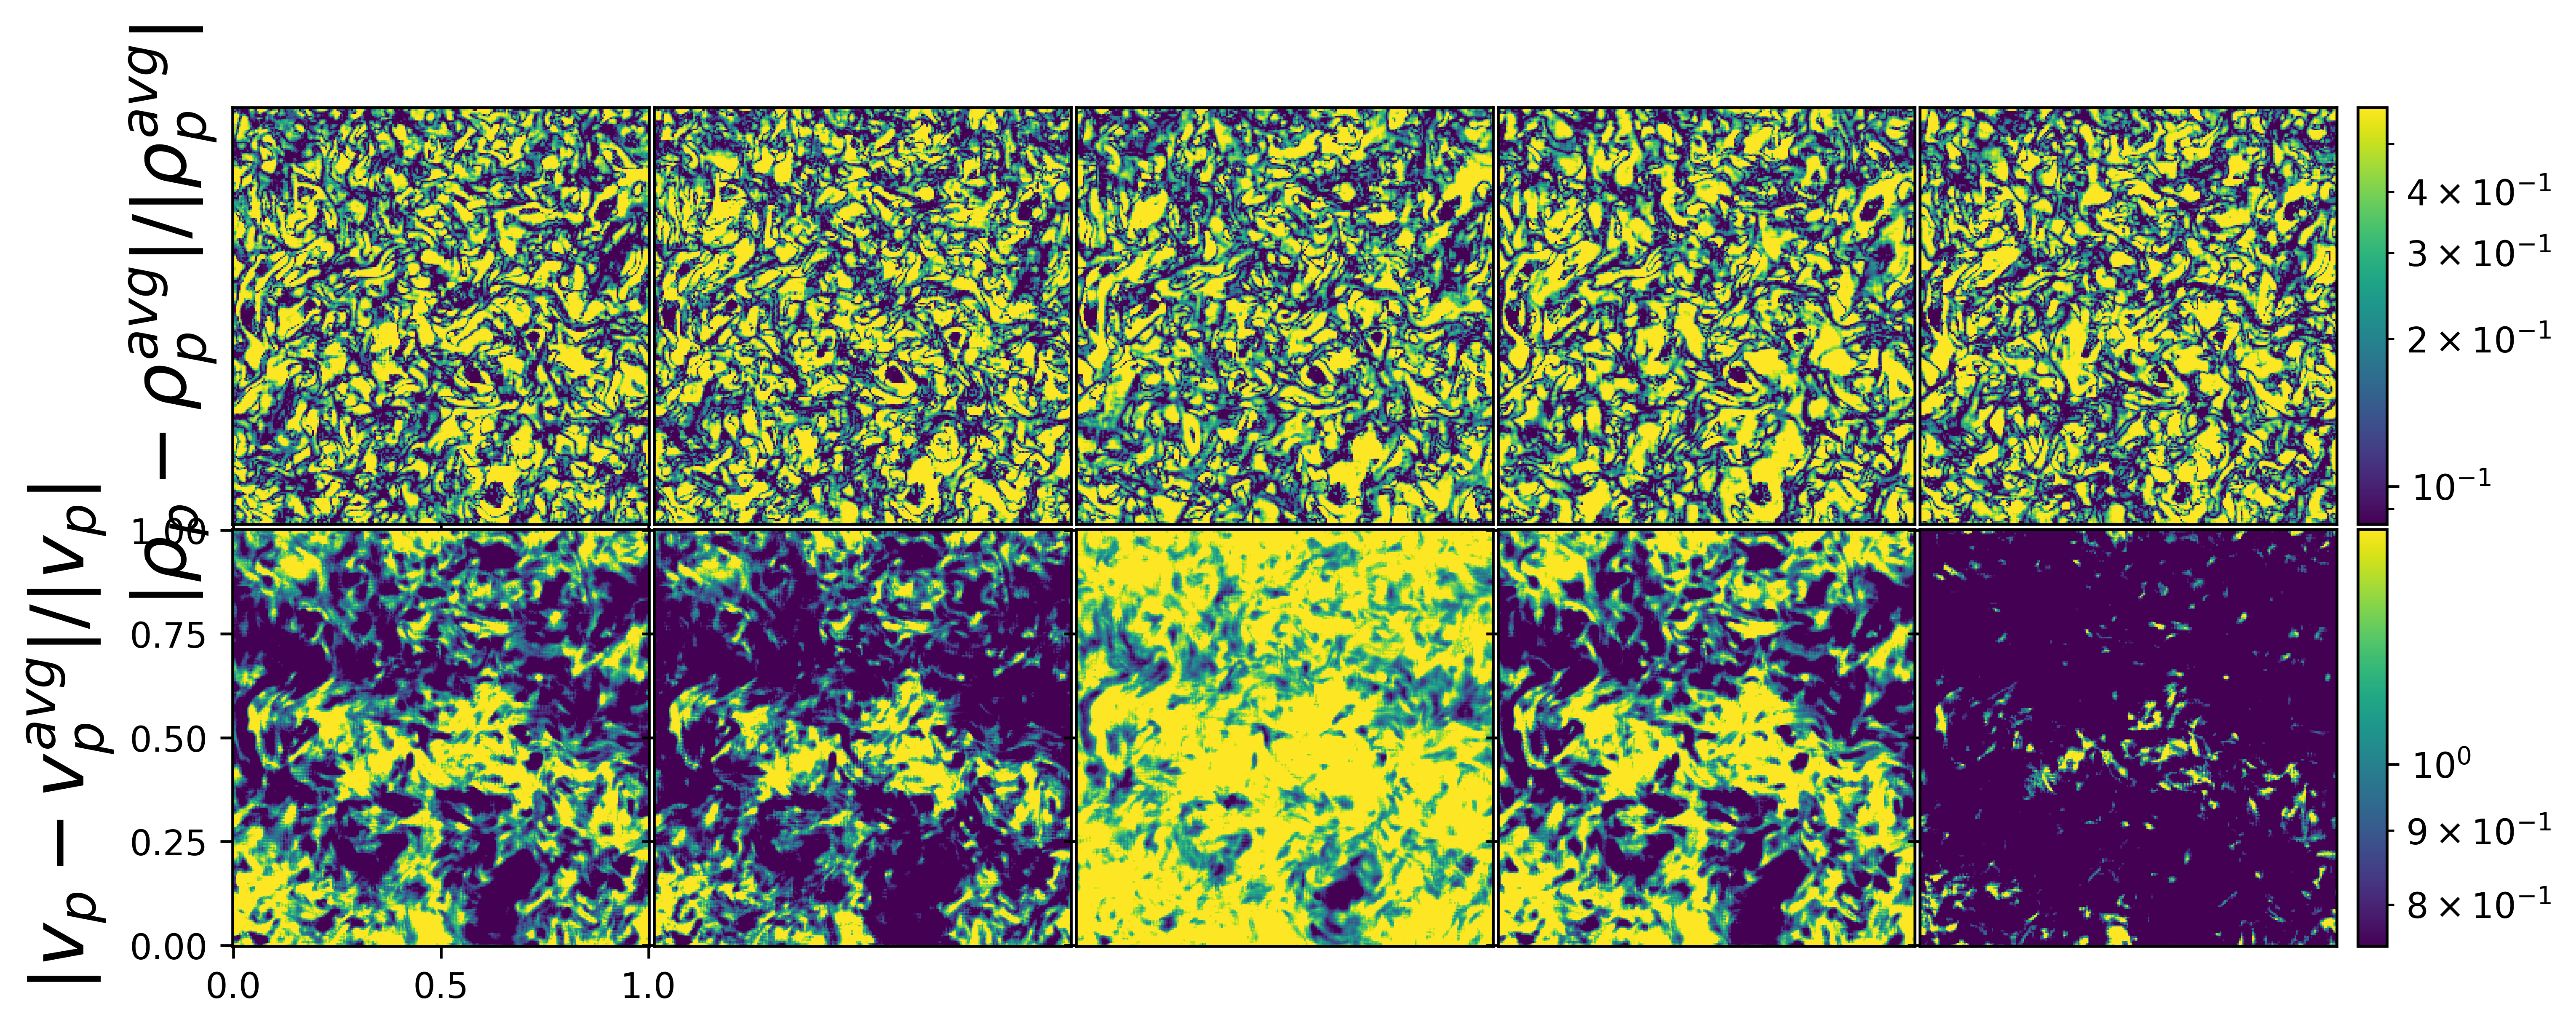

In [61]:
fig = plt.figure(figsize=(11,8),dpi=600)
grid = AxesGrid(fig,111,
                nrows_ncols=(2,5),
                #label_mode='1',
                #share_all='row',
                cbar_location='right',
                cbar_mode='edge',
                cbar_size='7%',
                cbar_pad='5%')
x=np.linspace(0,1,256)
y=np.linspace(0,1,256)
X,Y = np.meshgrid(x,y)

for i in range(5):
    rhop_error = ((abs(rhop_slices[i]-rhop_avg))/(rhop_avg+eps))
    if i == 0:
        ql,qh = np.quantile(rhop_error,[0.20,0.80])
        eps = np.unique(rhop_error)[1]
        print(eps)
    im = grid[i].pcolormesh(X,Y,rhop_error[0,256//2,:,:]+eps,
                       rasterized=True,shading='auto',
                       norm=colors.LogNorm(vmin=ql, vmax=qh)
                      )
grid.cbar_axes[0].colorbar(im)
grid[0].set_ylabel(r'$|\rho_p-\rho_p^{avg}|/|\rho_p^{avg}|$',fontsize=21)
grid[0].set_yticks([])

for i in range(5):
    velc_deviation = np.sqrt(np.sum((vrel_slices[i]-vrel_avg)**2,axis=0))
    velc_err = (velc_deviation/(np.abs(np.sqrt(np.sum(vrel_avg**2,axis=0)))+eps))
    if i == 0:
        ql,qh = np.quantile(velc_err,[0.20,0.80])
    im = grid[5+i].pcolormesh(X,Y,velc_err[256//2,:,:],
                                rasterized=True,shading='auto',
                                norm=colors.LogNorm(vmin=ql,vmax=qh)
                             )
        
    if i != 0:
        grid[5+i].set_xticks([])
grid[5].set_ylabel(r'$|v_p-v_p^{avg}|/|v_p|$',fontsize=21)
grid.cbar_axes[1].colorbar(im)

NameError: name 'demo_bottom_cbar' is not defined

<Figure size 396x180 with 0 Axes>